In [1]:
#import 相关库
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tqdm
import sys
import os
import gc
import argparse
import warnings
warnings.filterwarnings('ignore')

In [18]:
# 读取数据
train_power_forecast_history = pd.read_csv('./data/train/power_forecast_history.csv')
train_power = pd.read_csv('./data/train/power.csv')
train_stub_info = pd.read_csv('./data/train/stub_info.csv')

test_power_forecast_history = pd.read_csv('./data/test/power_forecast_history.csv')
test_stub_info = pd.read_csv('./data/test/stub_info.csv')

In [19]:
# 聚合数据
train_df = train_power_forecast_history.groupby(['id_encode','ds']).head(1)
del train_df['hour']

In [21]:
test_df = test_power_forecast_history.groupby(['id_encode','ds']).head(1)
del test_df['hour']

In [22]:
tmp_df = train_power.groupby(['id_encode','ds'])['power'].sum()
tmp_df.columns = ['id_encode','ds','power']

# 合并充电量数据
train_df = train_df.merge(tmp_df, on=['id_encode','ds'], how='left')

### 合并数据
train_df = train_df.merge(train_stub_info, on='id_encode', how='left')
test_df = test_df.merge(test_stub_info, on='id_encode', how='left')

In [23]:
train_df

,id_encode,hour,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,ds,power,parking_free,flag,h3,ac_equipment_kw,dc_equipment_kw
0,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,2288.2240,1.0,A,85309ea7fffffff,0.0,1440.0
1,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220416,2398.5730,1.0,A,85309ea7fffffff,0.0,1440.0
2,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220417,2313.0330,1.0,A,85309ea7fffffff,0.0,1440.0
3,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220418,2095.3259,1.0,A,85309ea7fffffff,0.0,1440.0
4,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220419,1834.3590,1.0,A,85309ea7fffffff,0.0,1440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149039,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230410,653.9099,1.0,A,85309ca3fffffff,0.0,540.0
149040,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230411,663.0800,1.0,A,85309ca3fffffff,0.0,540.0
149041,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230412,678.3201,1.0,A,85309ca3fffffff,0.0,540.0
149042,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230413,704.5300,1.0,A,85309ca3fffffff,0.0,540.0


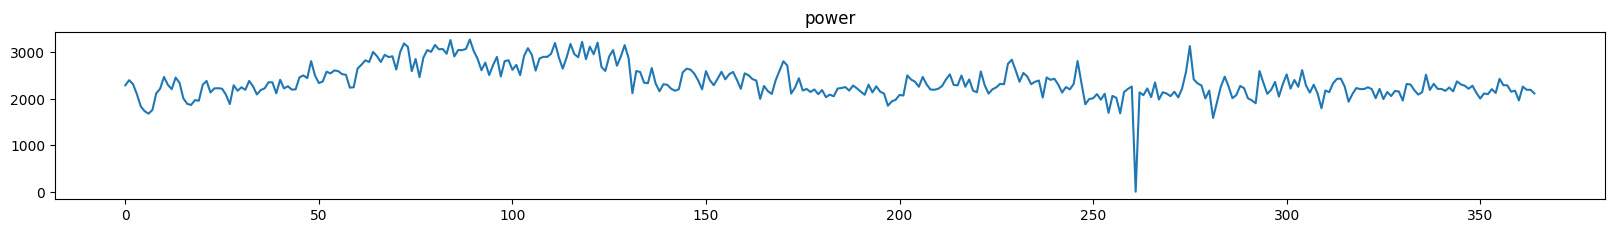

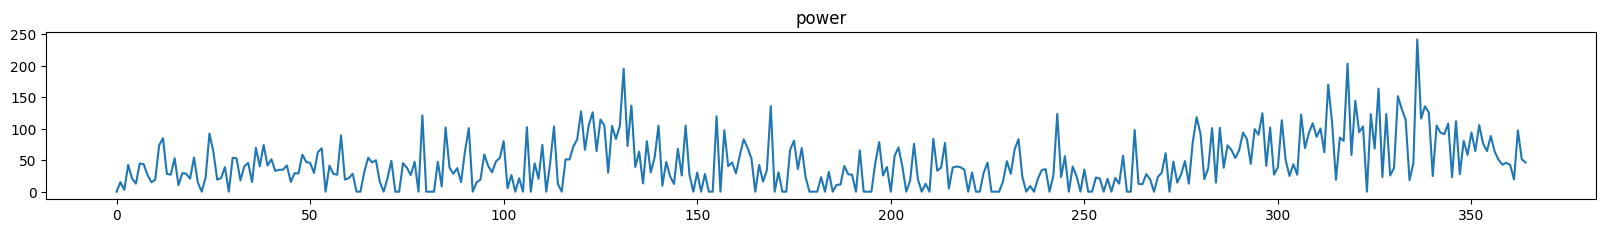

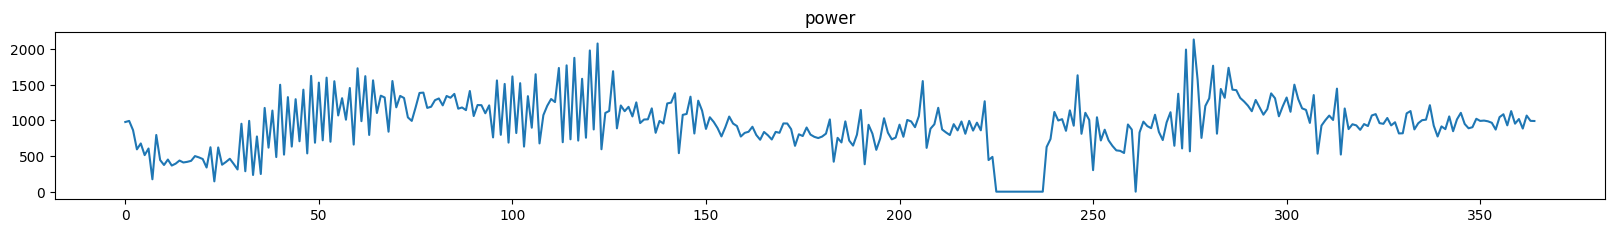

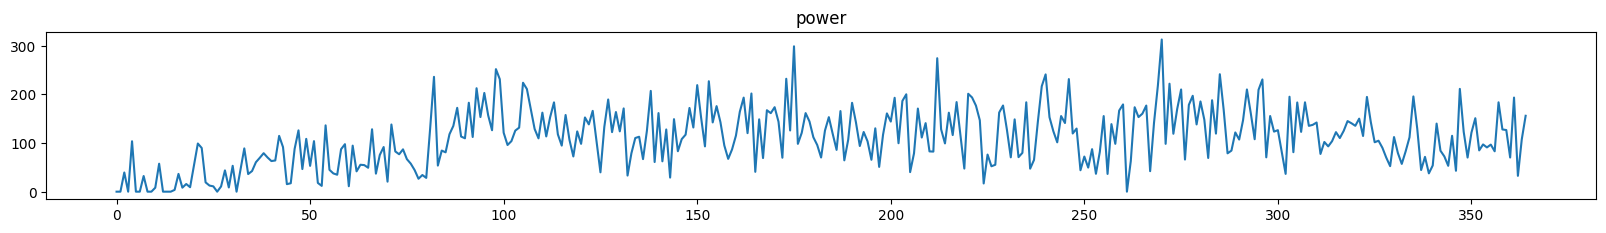

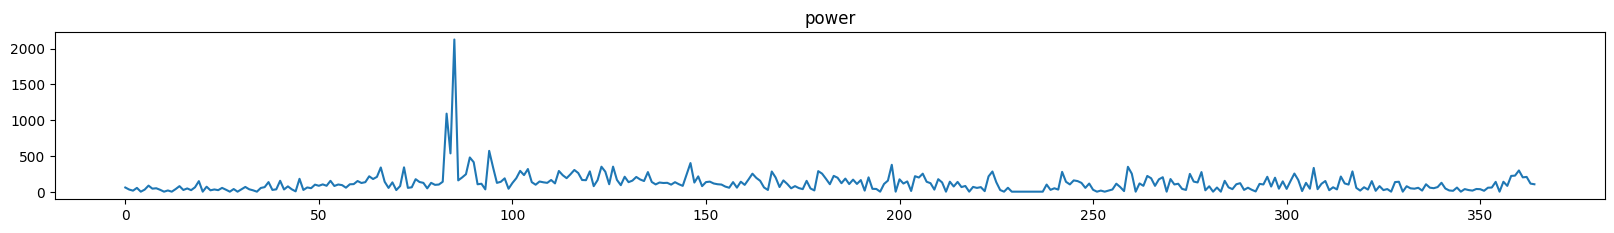

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

In [24]:
# 定义要绘制的列
cols = ['power']

# 遍历id_encode的五个值
for ie in [0,1,2,3,4]:

    # 获取train_df中id_encode为当前值ie的所有行，并重置索引
    tmp_df = train_df[train_df['id_encode']==ie].reset_index(drop=True)

    # 再次重置索引，并为新索引添加一个名为'index'的列
    tmp_df = tmp_df.reset_index(drop=True).reset_index()

    # 遍历要绘制的列
    for num, col in enumerate(cols):

        # 设置图的大小
        plt.figure(figsize=(20,10))

        # 创建子图，总共有4行1列，当前为第num+1个子图
        plt.subplot(4,1,num+1)

        # 绘制图形：x轴为'index'，y轴为当前列的值
        plt.plot(tmp_df['index'],tmp_df[col])

        # 为当前子图设置标题，标题为当前列的名称
        plt.title(col)

# 显示图形
plt.show()

# 创建一个新的图，大小为20x5
plt.figure(figsize=(20,5))


In [25]:
### 数据预处理
train_df['flag'] = train_df['flag'].map({'A':0,'B':1})
test_df['flag'] = test_df['flag'].map({'A':0,'B':1})

In [26]:
train_df.head()

,id_encode,hour,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,ds,power,parking_free,flag,h3,ac_equipment_kw,dc_equipment_kw
0,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,2288.2240,1.0,0,85309ea7fffffff,0.0,1440.0
1,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220416,2398.5730,1.0,0,85309ea7fffffff,0.0,1440.0
2,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220417,2313.0330,1.0,0,85309ea7fffffff,0.0,1440.0
3,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220418,2095.3259,1.0,0,85309ea7fffffff,0.0,1440.0
4,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220419,1834.3590,1.0,0,85309ea7fffffff,0.0,1440.0


In [27]:
def get_time_feature(df, col):
    
    df_copy = df.copy()
    prefix = col + "_"
    df_copy['new_'+col] = df_copy[col].astype(str)
    
    col = 'new_'+col
    df_copy[col] = pd.to_datetime(df_copy[col], format='%Y%m%d')
    df_copy[prefix + 'year'] = df_copy[col].dt.year
    df_copy[prefix + 'month'] = df_copy[col].dt.month
    df_copy[prefix + 'day'] = df_copy[col].dt.day
    # df_copy[prefix + 'weekofyear'] = df_copy[col].dt.weekofyear # 日期时间对象所在年份的周数
    df_copy[prefix + 'dayofweek'] = df_copy[col].dt.dayofweek # 日期时间对象的星期几，星期一为0，星期日为6。
    df_copy[prefix + 'is_wknd'] = df_copy[col].dt.dayofweek // 6 # 是否为周末，是周末，则为1，否则为0。
    df_copy[prefix + 'quarter'] = df_copy[col].dt.quarter # 所在年份的季度
    df_copy[prefix + 'is_month_start'] = df_copy[col].dt.is_month_start.astype(int) # 是否为月初，月初，则为1，否则为0。
    df_copy[prefix + 'is_month_end'] = df_copy[col].dt.is_month_end.astype(int) # 是否为月末，月末，则为1，否则为0。
    del df_copy[col]
    
    return df_copy   
    
train_df = get_time_feature(train_df, 'ds')
test_df = get_time_feature(test_df, 'ds')

cols = [f for f in test_df.columns if f not in ['ds','power','h3']]

In [28]:
train_df

,id_encode,hour,ele_price,ser_price,after_ser_price,total_price,f1,f2,f3,ds,...,ac_equipment_kw,dc_equipment_kw,ds_year,ds_month,ds_day,ds_dayofweek,ds_is_wknd,ds_quarter,ds_is_month_start,ds_is_month_end
0,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220415,...,0.0,1440.0,2022,4,15,4,0,2,0,0
1,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220416,...,0.0,1440.0,2022,4,16,5,0,2,0,0
2,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220417,...,0.0,1440.0,2022,4,17,6,1,2,0,0
3,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220418,...,0.0,1440.0,2022,4,18,0,0,2,0,0
4,0,0.0,0.64,0.95,0.31,1.59,0.0,0.0,1.0,20220419,...,0.0,1440.0,2022,4,19,1,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149039,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230410,...,0.0,540.0,2023,4,10,0,0,2,0,0
149040,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230411,...,0.0,540.0,2023,4,11,1,0,2,0,0
149041,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230412,...,0.0,540.0,2023,4,12,2,0,2,0,0
149042,499,0.0,0.00,0.51,0.51,0.51,3.0,1240.0,NaN,20230413,...,0.0,540.0,2023,4,13,3,0,2,0,0


In [10]:
# 模型训练与验证

# 使用K折交叉验证训练和验证模型
def cv_model(clf, train_x, train_y, test_x, seed=2023):
    # 定义折数并初始化KFold
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    # 初始化oof预测和测试集预测
    oof = np.zeros(train_x.shape[0])
    test_predict = np.zeros(test_x.shape[0])
    cv_scores = []

    # KFold交叉验证
    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]
        
        # 转换数据为lightgbm数据格式
        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        # 定义lightgbm参数
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'min_child_weight': 5,
            'num_leaves': 2 ** 7,
            'lambda_l2': 10,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 4,
            'learning_rate': 0.1,
            'seed': 2023,
            'nthread' : 16,
            'verbose' : -1,
            # 'device':'gpu'
        }

        # 训练模型
        model = clf.train(params, train_matrix, 3000, valid_sets=[train_matrix, valid_matrix], categorical_feature=[]
                         , verbose_eval=500, early_stopping_rounds=200)
        
        # 获取验证和测试集的预测值
        val_pred = model.predict(val_x, num_iteration=model.best_iteration)
        test_pred = model.predict(test_x, num_iteration=model.best_iteration)
        
        oof[valid_index] = val_pred
        test_predict += test_pred / kf.n_splits
        
        # 计算并打印当前折的分数
        score = np.sqrt(mean_squared_error(val_pred, val_y))
        cv_scores.append(score)
        print(cv_scores)
        
    return oof, test_predict

# 调用上面的函数进行模型训练和预测
lgb_oof, lgb_test = cv_model(lgb, train_df[cols], train_df['power'], test_df[cols])


************************************ 1 ************************************
[266.7260370569527]
************************************ 2 ************************************
[266.7260370569527, 269.9232639345857]
************************************ 3 ************************************
[266.7260370569527, 269.9232639345857, 265.154677843001]
************************************ 4 ************************************
[266.7260370569527, 269.9232639345857, 265.154677843001, 265.21192193943574]
************************************ 5 ************************************
[266.7260370569527, 269.9232639345857, 265.154677843001, 265.21192193943574, 266.49163591068003]


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
            'min_child_weight': [5,8],
            'num_leaves': [2**4,2 ** 7],
            'lambda_l2': [10],
            'feature_fraction': [0.8],
            'bagging_fraction': [0.8],
            'bagging_freq': [4],
            'learning_rate': [0.03,0.1],
            'seed': [2023],
            'nthread' : [16],
            'verbose' : [-1],
            # 'device':'gpu'
        }
model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse')
grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(train_df[cols], train_df['power'])
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score: ", -grid_search.best_score_)
best_model = grid_search.best_estimator_

Best parameters found:  {'bagging_fraction': 0.8, 'bagging_freq': 4, 'feature_fraction': 0.8, 'lambda_l2': 10, 'learning_rate': 0.03, 'min_child_weight': 5, 'nthread': 16, 'num_leaves': 16, 'seed': 2023, 'verbose': -1}
Best RMSE score:  1024.2504447451197


In [34]:
lgb_test=best_model.predict(test_df[cols])

In [35]:
#输出赛题提交格式的结果
test_df['power'] = lgb_test
test_df['power'] = test_df['power'].apply(lambda x: 0 if x<0 else x)
test_df[['id_encode','ds','power']].to_csv('result.csv', index=False)